In [95]:
##          DATA SHAPE DEFINITION           ##
import os
import json

# Define the parameters for the data shape
videos_per_handsign = 136  # Adjust if necessary
frames_per_video = 8
num_landmarks = 51
num_coordinates = 3

data_augmentation = True
num_augmented_versions = 4  # How many videos will be created from augmenting each video from the dataset

# Define the root directory containing handsign folders
root_path = "ACOTADONomenclatedDataset"

def get_handsign_folders(root_path):
    handsign_names = {}
    handsign_count = 0
    
    # Walk through the root directory
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        
        # Ignore non-directories
        if not os.path.isdir(folder_path):
            continue

        # If the folder starts with "#", check its subdirectories
        if folder.startswith("#"):
            for subfolder in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder)
                if os.path.isdir(subfolder_path):
                    handsign_names[handsign_count] = subfolder
                    handsign_count += 1
        else:
            # Directly add the folder as a handsign
            handsign_names[handsign_count] = folder
            handsign_count += 1
    
    return handsign_names

# Get the handsign names automatically
handsign_names = get_handsign_folders(root_path)
num_handsigns = len(handsign_names)

# Output the handsign names and number of handsigns
print(f"Number of handsigns: {num_handsigns}")
print("Handsign names:")
print(json.dumps(handsign_names, indent=4))

Number of handsigns: 4
Handsign names:
{
    "0": "apellido",
    "1": "C",
    "2": "cumplea\u00f1os",
    "3": "mujer"
}


In [96]:
import numpy as np
# Generate dummy data
data = [np.random.rand(videos_per_handsign, frames_per_video, num_landmarks, num_coordinates) for _ in range(num_handsigns)]

# Convert the list to a numpy array with shape (num_handsigns, videos_per_handsign, frames_per_video, num_landmarks, num_coordinates)
data_array = np.array(data)

# Save the data array to a .npy file
np.save('handsigns_data.npy', data_array)

In [97]:
##          PROCESS VIDEO DATASET FUNC DEFINITIONS         ##
import cv2
import mediapipe as mp
import os
from tqdm import tqdm
import warnings

def extract_landmarks(hands_results, pose_results, last_handedness):
    landmarks = []

    try:
        nose_landmark = pose_results.pose_landmarks.landmark[0]  # all landmarks are relative to the nose
    except:
        class nose_landmark:
            x = 0
            y = 0
            z = 0
        nose_landmark = nose_landmark()

    # Initialize placeholders for left and right hand landmarks
    left_hand_landmarks = [(0, 0, 0)] * 21
    right_hand_landmarks = [(0, 0, 0)] * 21

    # Extract hand landmarks with handedness labeling
    if hands_results.multi_hand_landmarks and hands_results.multi_handedness:
        for i, hand_landmarks in enumerate(hands_results.multi_hand_landmarks):
            label = hands_results.multi_handedness[i].classification[0].label  # 'Left' or 'Right'
            
            if label == 'Left':
                left_hand_landmarks = [(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) for lm in hand_landmarks.landmark]
                last_handedness['Left'] = True  # Mark the left hand as active
            elif label == 'Right':
                right_hand_landmarks = [(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) for lm in hand_landmarks.landmark]
                last_handedness['Right'] = True  # Mark the right hand as active

    # If one hand goes offscreen, attempt to use the last known handedness
    if not hands_results.multi_hand_landmarks or len(hands_results.multi_hand_landmarks) < 2:
        if not last_handedness.get('Left'):
            left_hand_landmarks = [(0, 0, 0)] * 21
        if not last_handedness.get('Right'):
            right_hand_landmarks = [(0, 0, 0)] * 21

    landmarks.extend(left_hand_landmarks)
    landmarks.extend(right_hand_landmarks)

    # Extract selected body landmarks (9 landmarks)
    selected_body_landmarks = [0, 11, 12, 13, 14, 15, 16, 23, 24]  # Landmarks for nose, arms, and shoulders
    if pose_results.pose_landmarks:
        for idx in selected_body_landmarks:
            lm = pose_results.pose_landmarks.landmark[idx]
            landmarks.append((lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z))
    else:
        landmarks.extend([(0, 0, 0)] * 9)

    return np.array(landmarks), last_handedness

def process_frame(frame, hands, pose, last_handedness):
    """
    This function processes a single frame, extracting the landmarks and ensuring hand consistency.
    """
    # Convert the BGR image to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image and extract landmarks
    hands_results = hands.process(image)
    pose_results = pose.process(image)

    # Extract landmarks with handedness robustness
    landmarks, last_handedness = extract_landmarks(hands_results, pose_results, last_handedness)

    return landmarks, last_handedness

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
    frame_set = set(indices)
    frame_count = 0

    last_handedness = {'Left': False, 'Right': False}  # To track which hands are present
    
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands, \
         mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        
        while cap.isOpened() and len(frames) < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count in frame_set:
                landmarks, last_handedness = process_frame(frame, hands, pose, last_handedness)  # Track handedness across frames
                frames.append(landmarks)

            frame_count += 1

    cap.release()

    # Pad if we don't have enough frames
    if len(frames) < frames_per_video:
        frames.extend([np.zeros((num_landmarks, num_coordinates))] * (frames_per_video - len(frames)))

    return np.array(frames)

def process_dataset(root_path, handsign_names):
    data = []
    
    for handsign_index in tqdm(range(len(handsign_names)), desc="Processing handsigns"):
        # Get the handsign folder name from the handsign_names dictionary
        handsign_folder = handsign_names[handsign_index]
        handsign_path = os.path.join(root_path, handsign_folder)
        
        if not os.path.exists(handsign_path):
            print(f"Warning: Directory {handsign_path} does not exist. Skipping.")
            data.append(np.zeros((videos_per_handsign, frames_per_video, num_landmarks, num_coordinates)))  # 51 landmarks total
            continue
        
        videos = [f for f in os.listdir(handsign_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        videos = videos[:videos_per_handsign]  # Limit to videos_per_handsign
        
        handsign_data = []
        for video in tqdm(videos, desc=f"Processing videos for handsign {handsign_index}", leave=False):
            video_path = os.path.join(handsign_path, video)
            video_data = process_video(video_path)
            handsign_data.append(video_data)
        
        # Pad if we don't have enough videos
        if len(handsign_data) < videos_per_handsign:
            padding_needed = videos_per_handsign - len(handsign_data)
            warnings.warn(f"Handsign {handsign_index} ('{handsign_folder}') has only {len(handsign_data)} videos. "
                          f"Padding with {padding_needed} empty videos.")
            handsign_data.extend([np.zeros((frames_per_video, num_landmarks, num_coordinates))] * padding_needed)
        
        data.append(np.array(handsign_data))
    
    return np.array(data)




In [98]:
##          PROCESS VIDEOS DATASET FUNC CALLING         ##
    
data_array = process_dataset(root_path, handsign_names)

# Save the data array to a .npy file
np.save('handsigns_data.npy', data_array)
print("Data saved to handsigns_data.npy")
    

Processing videos for handsign 1: 100%|██████████| 92/92 [00:57<00:00,  1.56it/s]
                                                                                 C:\Users\joaqu\AppData\Local\Temp\ipykernel_21080\1396058907.py:134: UserWarning: Handsign 1 ('C') has only 92 videos. Padding with 44 empty videos.
  warnings.warn(f"Handsign {handsign_index} ('{handsign_folder}') has only {len(handsign_data)} videos. "
Processing videos for handsign 2: 100%|██████████| 107/107 [01:17<00:00,  1.48it/s]
                                                                                   C:\Users\joaqu\AppData\Local\Temp\ipykernel_21080\1396058907.py:134: UserWarning: Handsign 2 ('cumpleaños') has only 107 videos. Padding with 29 empty videos.
  warnings.warn(f"Handsign {handsign_index} ('{handsign_folder}') has only {len(handsign_data)} videos. "
Processing handsigns: 100%|██████████| 4/4 [05:48<00:00, 87.15s/it]                

Data saved to handsigns_data.npy


In [92]:
##        DATA AUGMENTATION (OPTIONAL)        ##

#Augmentation parameters
noise_level=0.005 #for the add_noise() function
translation_vector=np.random.uniform(-0.05, 0.05, 3) #for the apply_translation() function
scale_factor=np.random.uniform(0.6, 1.6) #for the apply_scaling() function
angle_degrees=np.random.uniform(-25, 25) #for the apply_rotation()


def apply_rotation(landmarks, angle_degrees):
    """Rotate the landmarks in 3D space by a given angle."""
    angle_radians = np.radians(angle_degrees)
    cos_angle = np.cos(angle_radians)
    sin_angle = np.sin(angle_radians)

    # Rotation around the Z-axis (you can adjust for other axes if necessary)
    rotation_matrix = np.array([
        [cos_angle, -sin_angle, 0],
        [sin_angle, cos_angle, 0],
        [0, 0, 1]
    ])

    return np.dot(landmarks, rotation_matrix)

def apply_scaling(landmarks, scale_factor):
    """Scale the landmarks by a given factor."""
    return landmarks * scale_factor

def apply_translation(landmarks, translation_vector):
    """Translate the landmarks by a given vector (x, y, z)."""
    return landmarks + translation_vector

def add_noise(landmarks, noise_level=0.001):
    """Add random noise to the landmarks."""
    noise = np.random.normal(0, noise_level, landmarks.shape)
    return landmarks + noise

def augment_data(data_array, num_augmented_versions=5):
    """
    Augment the data array by applying transformations.
    Creates `num_augmented_versions` augmented copies of each handsign video.
    """
    augmented_data = []
    for handsign_data in data_array:
        augmented_handsign_data = []
        for video_data in handsign_data:
            augmented_videos = [video_data]  # Start with the original video data

            for _ in range(num_augmented_versions):
                augmented_video = []
                for frame in video_data:
                    # Apply a combination of augmentations
                    rotated_frame = apply_rotation(frame, angle_degrees)
                    scaled_frame = apply_scaling(rotated_frame, scale_factor)
                    translated_frame = apply_translation(scaled_frame, translation_vector)
                    noisy_frame = add_noise(translated_frame, noise_level)

                    augmented_video.append(noisy_frame)
                
                augmented_videos.append(np.array(augmented_video))

            # Flatten the augmented videos for each original video
            augmented_handsign_data.extend(augmented_videos)

        augmented_data.append(np.array(augmented_handsign_data))
    
    return np.array(augmented_data)

# Load original handsigns data
handsigns_data = np.load('handsigns_data.npy')

# Apply augmentation
if data_augmentation:
    
    augmented_data = augment_data(handsigns_data, num_augmented_versions)
    
    # Save the augmented data to a new .npy file
    np.save('handsigns_data_augmented.npy', augmented_data)
    
    # Update the videos per handsign value to match the videos generated by the augmentation
    data_array = np.load('handsigns_data_augmented.npy')
    videos_per_handsign = data_array.shape[1]
    
    print("Augmented data saved to handsigns_data_augmented.npy, videos_per_handsign augmented by "+str(num_augmented_versions)+" per existing video for a total of "+str(videos_per_handsign)+" videos per handsign")
else:
    print("no data augmentation was performed")

Augmented data saved to handsigns_data_augmented.npy, videos_per_handsign augmented by 1 per existing video for a total of 48 videos per handsign


In [53]:
##          MODEL DEFINITION            ##
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Reshape input to (frames_per_video, num_landmarks * num_coordinates)
new_input_shape = (frames_per_video, num_landmarks * num_coordinates)

model = Sequential([
    # Reshape layer
    Reshape((frames_per_video, num_landmarks * num_coordinates), input_shape=(frames_per_video, num_landmarks, num_coordinates)),
    
    # LSTM layers with Dropout and Batch Normalization to reduce overfitting
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Dropout(0.7),
    
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Dropout(0.7),
    
    # Fully connected layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
    BatchNormalization(),
    Dropout(0.7),
    
    # Output layer for multi-class classification
    Dense(num_handsigns, activation='softmax')  # Softmax for multi-class classification
])

# Specify a learning rate
learning_rate = 0.0005

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.summary() # Uncomment if you want to see the model summary


C:\Users\joaqu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
##          DATA PREPROCESSING FOR TRAINING            ##
from sklearn.model_selection import train_test_split
import shutil

# Load the data from the .npy file, making a copy to use for training as to not modify the original extracted data
if data_augmentation:
    shutil.copy('handsigns_data_augmented.npy', 'handsigns_data_training_copy.npy')
    data_array = np.load('handsigns_data_training_copy.npy')
    
    # Update videos_per_handsign based on augmentation
    #videos_per_handsign = data_array.shape[1]  # Dynamically update based on the new augmented shape
    print("after augmentation videos per handsign updated to: " + str(data_array.shape[1]))
else:
    shutil.copy('handsigns_data.npy', 'handsigns_data_training_copy.npy')
    data_array = np.load('handsigns_data_training_copy.npy')


# X remains unchanged
X = data_array 

# Create labels for each handsign (0 to num_handsigns-1)
# This creates a label for each hand sign, repeated for each video
y = np.repeat(np.arange(num_handsigns), videos_per_handsign)
y = y.reshape(num_handsigns, videos_per_handsign)

# Initialize lists to hold training and validation data
X_train_list = []
X_val_list = []
y_train_list = []
y_val_list = []

# Split videos and labels for each handsign
for handsign_index in range(num_handsigns):
    # Split the videos within each handsign
    train_indices, val_indices = train_test_split(
        np.arange(videos_per_handsign), 
        test_size=0.2, 
        random_state=42
    )
    
    # Select training and validation data for this handsign
    X_train_list.append(data_array[handsign_index, train_indices])
    X_val_list.append(data_array[handsign_index, val_indices])
    
    # Select corresponding labels
    y_train_list.append(y[handsign_index, train_indices])
    y_val_list.append(y[handsign_index, val_indices])

# Concatenate lists to form the final training and validation sets
X_train = np.concatenate(X_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Reshape X_train and X_val to fit the model's expected input shape
X_train = X_train.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
X_val = X_val.reshape(-1, frames_per_video, num_landmarks, num_coordinates)

# Flatten y_train and y_val
y_train = y_train.flatten()
y_val = y_val.flatten()

after augmentation videos per handsign updated to: 544


Epoch 1/500
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2946 - loss: 20.9840
Epoch 1: val_loss improved from inf to 16.42857, saving model to best_handsigns_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2982 - loss: 20.7788 - val_accuracy: 0.3440 - val_loss: 16.4286 - learning_rate: 5.0000e-04
Epoch 2/500
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3455 - loss: 16.5227
Epoch 2: val_loss improved from 16.42857 to 13.25227, saving model to best_handsigns_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3464 - loss: 16.4109 - val_accuracy: 0.3784 - val_loss: 13.2523 - learning_rate: 5.0000e-04
Epoch 3/500
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3985 - loss: 13.3120
Epoch 3: val_loss improved from 13.25227 to 10.95412, saving model to best_handsigns_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4004 - loss: 13.2384 - val_accuracy: 0.4037 - val_loss: 10.9541 - learning_rate: 5.0000e-04
Epoch 4/500
49/55 ━━

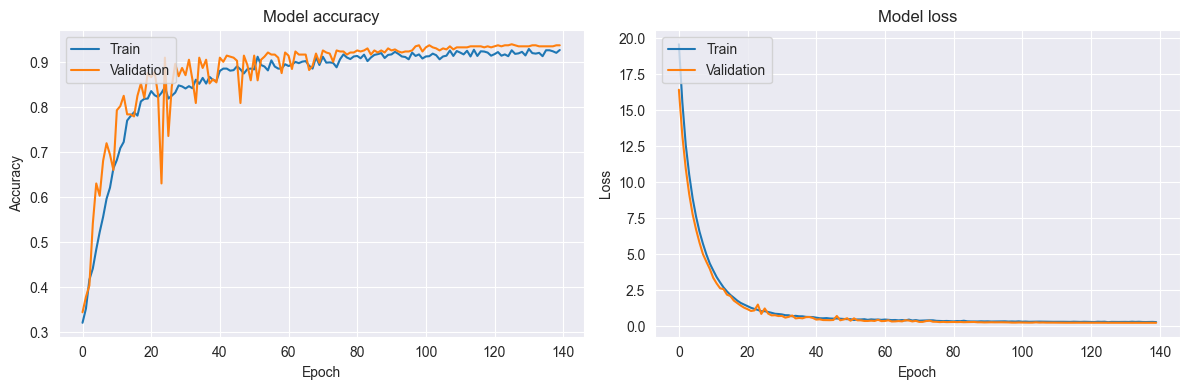

In [55]:
##          MODEL TRAINING          ##
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback helpers for model training #
# Early stopping to stop training when validation loss stops improving
# Model checkpointing to save the best model during training
# Reduce learning rate when a metric has stopped improving

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  
checkpoint = ModelCheckpoint('best_handsigns_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)  

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


# Save the trained model
model.save('handsigns_model.h5')

# Optionally, save the training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    

    
##          TRAINING HISTORY ANALYSIS           ##
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# If you want to save the plot instead of displaying it:
# plt.savefig('training_history.png')

In [ ]:
##          SINGLE VIDEO PREDICTION TEST         ##
def predict_handsign(video_path, model):
    # Process the video to extract landmarks
    video_data = process_video(video_path)
    
    # Reshape the data to match the model input shape (add batch dimension for a single video)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)
        # Make the prediction
    prediction = model.predict(video_data)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence  


if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('best_handsigns_model.keras')
    
    test_directory = "Model testing videos"
    for video_file in os.listdir(test_directory):
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(test_directory, video_file)
            predicted_class, confidence = predict_handsign(video_path, model)
            
            # Get hand sign name
            predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")
            
            # Apply confidence threshold
            if confidence < 0.7:
                predicted_handsign = "Inseguro ("+predicted_handsign+")"
                
            print(f"Video: {video_file}")
            print(f"Predicted Hand Sign: {predicted_handsign}")
            print(f"Confidence: {confidence:.2f}")
            print("--------------------")


In [56]:
##          CONTINUOUS PREDICTION WITH SLIDING WINDOW           ##

import collections
import cv2
import mediapipe as mp
import numpy as np 
import tensorflow as tf
from scipy.interpolate import interp1d  # For smoothing landmarks

# Load the trained model
model = tf.keras.models.load_model('best_handsigns_model.keras')

# Initialize Mediapipe solutions outside the loop for efficiency
mp_hands = mp.solutions.hands.Hands(static_image_mode=False, 
                                    max_num_hands=2, 
                                    min_detection_confidence=0.4,  # Lowered confidence to allow for fast movement detection
                                    min_tracking_confidence=0.4)   # Lowered tracking confidence
mp_pose = mp.solutions.pose.Pose(static_image_mode=False, 
                                 min_detection_confidence=0.4, 
                                 min_tracking_confidence=0.4)

# Open webcam feed
cap = cv2.VideoCapture(0)

# Sliding window buffer for frames
frame_buffer = collections.deque(maxlen=frames_per_video)

# To smooth predictions, keep track of recent predictions
prediction_buffer = collections.deque(maxlen=3)

# Store the last prediction
last_prediction = "No Prediction"
last_confidence = 0.0

# Track missing hands to reset landmarks if missing for too long
hand_missing_threshold = 5
left_hand_missing_count = 0
right_hand_missing_count = 0

# Store the last known hand landmarks to compare in future frames
last_left_hand_landmarks = None
last_right_hand_landmarks = None

# Movement delta threshold for fast movements
movement_threshold = 0.9  # Adjusted threshold for movement delta

# Smoothing factor for missing landmarks
smoothing_factor = 0.8  # Weight to smooth landmarks during quick movements

# Draw landmarks on the frame
def draw_landmarks(frame, landmarks):
    """Draw landmarks on the frame."""
    for i, (x, y, z) in enumerate(landmarks):
        h, w, _ = frame.shape
        x = int(x * w + 325)
        y = int(y * h + 250)
        
        if i < 21:  # Left hand landmarks
            color = (0, 255, 0)
        elif i < 42:  # Right hand landmarks
            color = (0, 0, 255)
        else:  # Body landmarks
            color = (255, 0, 0)
        
        cv2.circle(frame, (x, y), 5, color, -1)

def smooth_landmarks(new_landmarks, old_landmarks):
    """Smooth landmarks by interpolating between old and new."""
    if old_landmarks is None:
        return new_landmarks

    return old_landmarks * (1 - smoothing_factor) + new_landmarks * smoothing_factor

def process_frame(frame):
    global last_left_hand_landmarks, last_right_hand_landmarks
    global left_hand_missing_count, right_hand_missing_count

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hands_results = mp_hands.process(image)
    pose_results = mp_pose.process(image)

    # Initialize a zero-filled array for landmarks (51 landmarks, each with x, y, z)
    landmarks = np.zeros((num_landmarks, num_coordinates))

    # Detect nose for relative normalization
    try:
        nose_landmark = pose_results.pose_landmarks.landmark[0]
    except:
        class nose_landmark:
            x = 0
            y = 0
            z = 0
        nose_landmark = nose_landmark()

    if hands_results.multi_hand_landmarks:
        handedness_labels = [hand.classification[0].label for hand in hands_results.multi_handedness]

        for i, hand_landmarks in enumerate(hands_results.multi_hand_landmarks):
            if handedness_labels[i] == 'Left':
                left_hand = np.array([(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) 
                                      for lm in hand_landmarks.landmark])

                # Smooth the transition between frames
                left_hand = smooth_landmarks(left_hand, last_left_hand_landmarks)
                
                # Update the stored landmarks for the next frame
                last_left_hand_landmarks = left_hand
                landmarks[:21] = left_hand  # Insert the left hand landmarks into the first 21 slots

            elif handedness_labels[i] == 'Right':
                right_hand = np.array([(lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z) 
                                       for lm in hand_landmarks.landmark])

                # Smooth the transition between frames
                right_hand = smooth_landmarks(right_hand, last_right_hand_landmarks)
                
                # Update the stored landmarks for the next frame
                last_right_hand_landmarks = right_hand
                landmarks[21:42] = right_hand  # Insert the right hand landmarks into slots 21-42

        # Reset the missing counts if hands are detected
        left_hand_missing_count = 0
        right_hand_missing_count = 0
    else:
        # Increment missing count when hands are not detected
        left_hand_missing_count += 1
        right_hand_missing_count += 1

        # Reuse last known landmarks if available and hands are missing for too long
        if last_left_hand_landmarks is not None:
            landmarks[:21] = last_left_hand_landmarks
        if last_right_hand_landmarks is not None:
            landmarks[21:42] = last_right_hand_landmarks

        # Reset landmarks if hands are missing for too long
        if left_hand_missing_count > hand_missing_threshold:
            last_left_hand_landmarks = None
        if right_hand_missing_count > hand_missing_threshold:
            last_right_hand_landmarks = None

    # Fill in body landmarks (9 selected)
    selected_body_landmarks = [0, 11, 12, 13, 14, 15, 16, 23, 24]
    if pose_results.pose_landmarks:
        for idx, landmark_idx in enumerate(selected_body_landmarks):
            lm = pose_results.pose_landmarks.landmark[landmark_idx]
            landmarks[42 + idx] = (lm.x - nose_landmark.x, lm.y - nose_landmark.y, lm.z - nose_landmark.z)

    return landmarks


# Make a prediction based on the buffer
def predict_handsign(buffer):
    """Make a prediction based on a buffer of frames."""    
    video_data = np.array(buffer)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)

    # Make prediction
    prediction = model.predict(video_data, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    return predicted_class, confidence


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    # Process every frame (no skipping)
    landmarks = process_frame(frame)

    # Add the landmarks to the frame buffer
    frame_buffer.append(landmarks)

    # Draw the landmarks on the frame
    draw_landmarks(frame, landmarks)

    # Once the buffer is full, make a prediction using the sliding window
    if len(frame_buffer) == frames_per_video:
        predicted_class, confidence = predict_handsign(frame_buffer)
        predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")

        # Update the last prediction
        last_prediction = predicted_handsign
        last_confidence = confidence

        # Store prediction and confidence in the buffer for smoothing
        print((predicted_class, confidence))
        prediction_buffer.append((predicted_class, confidence))

        # Average the last N predictions to smooth the output
        avg_pred_class = np.argmax(np.bincount([p[0] for p in prediction_buffer]))
        avg_confidence = np.mean([p[1] for p in prediction_buffer if p[0] == avg_pred_class])

        if avg_confidence > 0.8:
            last_prediction = handsign_names.get(avg_pred_class, f"HandSign_{avg_pred_class}")
            last_confidence = avg_confidence
        elif 0.45 < avg_confidence < 0.8:
            last_prediction = "deteccion insegura: "+handsign_names.get(avg_pred_class, f"HandSign_{avg_pred_class}")
            last_confidence = avg_confidence
        else:
            last_prediction = "deteccion nula"
            last_confidence = avg_confidence
            
    # Display the last prediction on the frame
    cv2.putText(frame, f"Predicted: {last_prediction} Conf: {last_confidence:.2f}", 
                (10, 30), cv2.FONT_ITALIC, 0.7, (0, 0, 0), 2)

    cv2.imshow('Hands Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\joaqu\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(0, 0.97838724)
(0, 0.9954774)
(0, 0.9951037)
(0, 0.98615175)
(0, 0.90928227)
(0, 0.57304335)
(1, 0.447943)
(3, 0.5251119)
(3, 0.5808057)
(3, 0.6230256)
(3, 0.46068683)
(3, 0.3753471)
(3, 0.33169287)
(1, 0.2860005)
(0, 0.3087752)
(0, 0.38757145)
(0, 0.4074373)
(0, 0.4067363)
(0, 0.39298075)
(0, 0.39478242)
(0, 0.39286348)
(0, 0.39237496)
(0, 0.40828562)
(0, 0.46494734)
(0, 0.5032218)
(0, 0.52032244)
(0, 0.642009)
(0, 0.73598945)
(0, 0.81641126)
(0, 0.8003146)
(0, 0.6032168)
(1, 0.59286636)
(1, 0.8880304)
(1, 0.96464425)
(1, 0.9880172)
(1, 0.9956136)
(1, 0.9979652)
(1, 0.9989237)
(1, 0.9993399)
(1, 0.9994486)
(1, 0.9994886)
(1, 0.99949515)
(1, 0.999496)
(1, 0.99951375)
(1, 0.99952877)
(1, 0.99953794)
(1, 0.9995347)
(1, 0.9995153)
(1, 0.99947065)
(1, 0.9993887)
(1, 0.9992411)
(1, 0.99898654)
(1, 0.9985514)
(1, 0.9976993)
(1, 0.99588)
(1, 0.99127066)
(1, 0.98447937)
(1, 0.97032386)
(1, 0.9539358)
(1, 0.9378359)
(1, 0.9046542)
(1, 0.85538435)
(1, 0.7829272)
(1, 0.75513375)
(1, 0.7424793)
(

In [ ]:

##          MODEL TESTING          ##

import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_test_data(test_data_path):
    # Reuse the process_dataset function
    test_data = process_dataset(test_data_path)
    
    # Reshape the data to match the model input shape
    X_test = test_data.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
    y_test = np.repeat(np.arange(num_handsigns), videos_per_handsign)
    
    return X_test, y_test

def evaluate_model(model, X_test, y_test):
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    return y_pred_classes

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def visualize_misclassifications(X_test, y_test, y_pred, num_samples=5):
    misclassified = np.where(y_test != y_pred)[0]
    np.random.shuffle(misclassified)
    
    for i in range(min(num_samples, len(misclassified))):
        idx = misclassified[i]
        plt.figure(figsize=(10, 5))
        
        # Plot a representation of the hand sign (e.g., first frame landmarks)
        plt.subplot(1, 2, 1)
        plt.scatter(X_test[idx, 0, :, 0], X_test[idx, 0, :, 1])
        plt.title(f"True: {y_test[idx]}, Predicted: {y_pred[idx]}")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        
        # Plot the confidence scores for each class
        plt.subplot(1, 2, 2)
        confidence_scores = model.predict(X_test[idx:idx+1])[0]
        plt.bar(range(num_handsigns), confidence_scores)
        plt.title("Confidence Scores")
        plt.xlabel("Hand Sign Class")
        plt.ylabel("Confidence")
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('handsigns_model.h5')
    
    # Load and preprocess test data
    test_data_path = "Model testing videos"  # Replace with your test dataset path
    X_test, y_test = load_and_preprocess_test_data(test_data_path)
    
    # Evaluate the model
    y_pred = evaluate_model(model, X_test, y_test)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Visualize some misclassifications
    visualize_misclassifications(X_test, y_test, y_pred)